In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lib
from sklearn.model_selection import train_test_split
import pickle

# This is project regarding Voice sample to Gender

* **Dataset** :  Common voice dataset is used here in this project

### Libraries
* Numpy (for mathematical calculations)
* Pandas (To read dataset)
* Matplotlib and Seaborn (visualization)
* Librosa (Audio analysis)
* sklearn (model training and analysis)

In [2]:
data = pd.read_csv("/kaggle/input/common-voice/cv-other-train.csv")
data.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-other-train/sample-000000.mp3,he had to spit some tobacco out of his mouth,0,0,seventies,male,england,NaN
1,cv-other-train/sample-000001.mp3,it took her a while to get used to it,1,1,twenties,male,scotland,NaN
2,cv-other-train/sample-000002.mp3,you will need some rubber boots,0,0,NaN,NaN,NaN,NaN
3,cv-other-train/sample-000003.mp3,you can speak a label to click on an element,0,0,fourties,male,us,NaN
4,cv-other-train/sample-000004.mp3,the priest collapsed backwards,0,0,NaN,NaN,NaN,NaN


In [3]:
data.isnull().sum()

filename           0
text               2
up_votes           0
down_votes         0
age            81433
gender         81490
accent         90559
duration      145135
dtype: int64

### Data cleaning

* Here I converted the genders (Here **Male** and **Female**) into 0 and 1 
* After that dropped all the rows which have NA as lable in gender
* Then dropped all other columns which will not be use in the project

In [4]:
gen = {
    'male':1,
    'female':0
}
data['gender'] = data['gender'].map(gen)
data=data.dropna(subset=['gender'])
data=data.drop(columns=['text','up_votes','down_votes','age','accent','duration'])
data.head()

,filename,gender
0,cv-other-train/sample-000000.mp3,1.0
1,cv-other-train/sample-000001.mp3,1.0
3,cv-other-train/sample-000003.mp3,1.0
5,cv-other-train/sample-000005.mp3,1.0
7,cv-other-train/sample-000007.mp3,0.0


In [5]:
data.isnull().sum()

filename    0
gender      0
dtype: int64

# Audio Feature Extraction Fuction

### Memoize Function 
* **Cache Dictionary**: Stores results of function calls.
* **@wraps**: Preserves the original function’s metadata.
* **Wrapper Function**: Checks if the result is in the cache. If not, it computes and stores it.

### Audio feature extraction:
This code has few components
1. At first I remove the silent portions from the audio (Here silence means certain sound portion in a audio portion)
2. Ensuring the audio size after removing some portions of the audio
3. After that I have adjust some parameters dynamically (Here fft stands for Fast Fourier Transform , mels for Melody)
4. Next I get the MFCC(Mel-Frequency Cepstral Coefficient) from the audio
5. After that I extracted the other audio features like Chroma and Zero crossing rate

In [6]:
# Feature extraction funtion 
# MFCC data will be extracted from the audio

from functools import wraps
import os

def memoize(f):
    cache = {}
    
    @wraps(f)
    def wrapper(file_path):
        if file_path not in cache:
            cache[file_path] = f(file_path)
        return cache[file_path]
    
    return wrapper

@memoize
def extract_audio_feature(file_path):
    path = "/kaggle/input/common-voice/cv-other-train/"
    dt, sr = lib.load(path + file_path, sr=None) 

    # Remove silent portions
    non_silent_intervals = lib.effects.split(dt, top_db=20) 
    non_silent_audio = np.concatenate([dt[start:end] for start, end in non_silent_intervals])

    # Minimum lenght
    min_length = 2048
    if len(non_silent_audio) < min_length:
        non_silent_audio = np.pad(non_silent_audio, (0, min_length - len(non_silent_audio)), mode='constant')

    # Adjust parameters dynamically
    n_fft = min(len(non_silent_audio), 512) 
    n_mels = min(40, len(non_silent_audio) // 20)  # Adjust n_mels based on audio length
    fmax = sr // 2 if sr // 2 < 8000 else 8000  # Adjust fmax based on sampling rate

    # Compute MFCC features
    mfcc_data = lib.feature.mfcc(y=non_silent_audio, sr=sr, n_mfcc=40, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
    
    # Compute additional statistical features from MFCC
    mfcc_mean = np.mean(mfcc_data.T, axis=0)
    mfcc_std = np.std(mfcc_data.T, axis=0)
    
    # Compute other basic features with adjusted n_fft
    chroma_stft = lib.feature.chroma_stft(y=non_silent_audio, sr=sr, n_fft=n_fft)
    chroma_mean = np.mean(chroma_stft.T, axis=0)
    chroma_std = np.std(chroma_stft.T, axis=0)
    
    zero_crossing_rate = lib.feature.zero_crossing_rate(y=non_silent_audio)
    zcr_mean = np.mean(zero_crossing_rate.T, axis=0)
    zcr_std = np.std(zero_crossing_rate.T, axis=0)
    
    # Combine all features
    features = np.concatenate((mfcc_mean, mfcc_std, chroma_mean, chroma_std, zcr_mean, zcr_std))
    
    return features

def process_chunk(chunk):
    return [extract_audio_feature(file_path) for file_path in chunk]
    

# Feature and Label creation

X is the dataframe of all the audio paths
y is the dataframe for the Labels

In [7]:
X = data['filename']
y = data['gender']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.55)

X_train = X_train.tolist()
y_train = y_train.tolist()

print(len(X_train))
print(type(X_train))
print(len(y_train))


28463
<class 'list'>
28463


### Feature extraction

Here we have made a chunks of data(divided data in several parts)so that we can use all the CPUs to enhance the speed of data extraction

Pool is used for create the multiprocessing envioronment and uses all the cpu(Here 4)

In [8]:
from multiprocessing import Pool
import os
cpu_count = os.cpu_count()
chunk_len = len(X_train) // cpu_count
chunks = [X_train[i:i + chunk_len] for i in range(0, len(X_train), chunk_len)]

with Pool(processes=cpu_count) as pool:
    results = pool.map(process_chunk, chunks)

# Flatten the list of results if necessary
all_res = [feature for sublist in results for feature in sublist]   

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Shaping and prepare all the data for Model

In [9]:
all_res = np.array(all_res)
gens = np.array([y_train],dtype=np.float64)
gens_ = gens.reshape(-1,1)
print(type(all_res))
print(gens_)
print(len(gens_))
print(len(all_res))

<class 'numpy.ndarray'>
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
28463
28463


# The Model

This model has 4 layers 
1. Input Layer
2. Hidden Layer 1
3. Hidden Layer 2
4. Output Layer 

### Initialization
    here we define all the parameters like input size , hidden layer sizes , learning rates (η) , dropout rate (p) 

### Sigmoid funtion

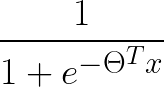

### reLU function

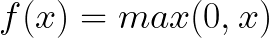

### reLU derivative

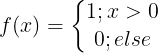


### DropOut function 

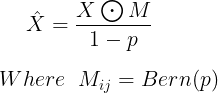






In [10]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, eta=0.01, p=0.1, regularization=0.01):
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size
        self.eta = eta
        self.p = p
        self.regularization = regularization
        
        # Weights initialization
        self.input_2_hidden_layer_1 = np.random.randn(self.input_size, self.hidden_size_1) * 0.01
        self.hidden_layer_1_2_hidden_layer_2 = np.random.randn(self.hidden_size_1, self.hidden_size_2) * 0.01
        self.hidden_layer_2_2_output = np.random.randn(self.hidden_size_2, self.output_size) * 0.01
        
        # Biases initialization
        self.b1 = np.zeros((1, self.hidden_size_1))
        self.b2 = np.zeros((1, self.hidden_size_2))
        self.bo = np.zeros((1, self.output_size))
        
    def reLU(self, Z):
        return np.maximum(0, Z)
    
    def dropout(self, X, p):
        prb = 1 - p
        M = np.random.rand(*X.shape) < prb
        return M * X / prb
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def reLU_derivative(self, X):
        return np.where(X > 0, 1, 0)
    
    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
        return loss
    
    def forward(self, X, isTraining=True):
        Z1 = np.dot(X, self.input_2_hidden_layer_1) + self.b1
        A1 = self.reLU(Z1)
        if isTraining:
            A1 = self.dropout(A1, self.p)

        Z2 = np.dot(A1, self.hidden_layer_1_2_hidden_layer_2) + self.b2
        A2 = self.reLU(Z2)
        if isTraining:
            A2 = self.dropout(A2, self.p)

        Z3 = np.dot(A2, self.hidden_layer_2_2_output) + self.bo
        A3 = self.sigmoid(Z3)
        
        self.Z1 = Z1
        self.A1 = A1
        self.Z2 = Z2
        self.A2 = A2
        self.Z3 = Z3
        self.A3 = A3

        return A3
    
    def backpropagation(self, X, y, output):
        m = y.shape[0]
        
        self.output_error = output - y.reshape(-1, 1)
        self.output_delta = self.output_error / m

        self.hidden_layer_2_error = self.output_delta.dot(self.hidden_layer_2_2_output.T)
        self.hidden_layer_2_delta = self.hidden_layer_2_error * self.reLU_derivative(self.Z2)

        self.hidden_layer_1_error = self.hidden_layer_2_delta.dot(self.hidden_layer_1_2_hidden_layer_2.T)
        self.hidden_layer_1_delta = self.hidden_layer_1_error * self.reLU_derivative(self.Z1)

        # Update weights with regularization
        self.hidden_layer_2_2_output -= (self.A2.T.dot(self.output_delta) + self.regularization * self.hidden_layer_2_2_output) * self.eta
        self.hidden_layer_1_2_hidden_layer_2 -= (self.A1.T.dot(self.hidden_layer_2_delta) + self.regularization * self.hidden_layer_1_2_hidden_layer_2) * self.eta
        self.input_2_hidden_layer_1 -= (X.T.dot(self.hidden_layer_1_delta) + self.regularization * self.input_2_hidden_layer_1) * self.eta

        # Update biases
        self.bo -= np.sum(self.output_delta, axis=0, keepdims=True) * self.eta
        self.b2 -= np.sum(self.hidden_layer_2_delta, axis=0, keepdims=True) * self.eta
        self.b1 -= np.sum(self.hidden_layer_1_delta, axis=0, keepdims=True) * self.eta
    
    def train(self, X_train, y_train, X_val, y_val, epochs=10000, patience=10):
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            output = self.forward(X_train)
            self.backpropagation(X_train, y_train, output)
            
            # Compute training loss
            train_loss = self.cross_entropy_loss(y_train, output)
            
            # Compute validation loss
            val_output = self.forward(X_val, isTraining=False)
            val_loss = self.cross_entropy_loss(y_val, val_output)
            
            if epoch % 1000 == 0:
                print(f'Epoch {epoch}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
            
            # Early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                self.save_model('best_model.pkl')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
        
        self.load_model('best_model.pkl')
    
    def predict(self, X):
        output = self.forward(X, isTraining=False)
        return np.round(output)
    def save_model(self, file_path):
        model_data = {
            'weights_input_2_hidden_layer_1': self.input_2_hidden_layer_1,
            'weights_hidden_layer_1_2_hidden_layer_2': self.hidden_layer_1_2_hidden_layer_2,
            'weights_hidden_layer_2_2_output': self.hidden_layer_2_2_output,
            'b1': self.b1,
            'b2': self.b2,
            'bo': self.bo
        }
        
        with open(file_path, 'wb') as f:
            pickle.dump(model_data, f)
    
    def load_model(self, file_path):
        with open(file_path, 'rb') as f:
            model_data = pickle.load(f)
            self.input_2_hidden_layer_1 = model_data['weights_input_2_hidden_layer_1']
            self.hidden_layer_1_2_hidden_layer_2 = model_data['weights_hidden_layer_1_2_hidden_layer_2']
            self.hidden_layer_2_2_output = model_data['weights_hidden_layer_2_2_output']
            self.b1 = model_data['b1']
            self.b2 = model_data['b2']
            self.bo = model_data['bo']

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(all_res)

X_train,X_temp,y_train,y_temp = train_test_split(X,gens_,test_size=0.45)
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.40)

In [12]:
model = NeuralNetwork(all_res.shape[1],64,64,1)
model.train(X_train,y_train,X_val,y_val,epochs=21000)

Epoch 0, Training Loss: 0.6931518714552818, Validation Loss: 0.69235138576567
Epoch 1000, Training Loss: 0.5237549819063702, Validation Loss: 0.5277308357889177
Epoch 2000, Training Loss: 0.5200862724506716, Validation Loss: 0.5246380247619051
Epoch 3000, Training Loss: 0.5153793954545796, Validation Loss: 0.5200638434187566
Epoch 4000, Training Loss: 0.35091275615234124, Validation Loss: 0.35309894238790335
Epoch 5000, Training Loss: 0.19503708931336783, Validation Loss: 0.2034215401214823
Epoch 6000, Training Loss: 0.16806931099402225, Validation Loss: 0.1799714703885128
Epoch 7000, Training Loss: 0.1593203886889041, Validation Loss: 0.1719559683228419
Epoch 8000, Training Loss: 0.1537586363925055, Validation Loss: 0.16678527735903897
Epoch 9000, Training Loss: 0.15022566223059275, Validation Loss: 0.16351601747624328
Epoch 10000, Training Loss: 0.1463143511815475, Validation Loss: 0.1612906906533961
Epoch 11000, Training Loss: 0.1448959446285285, Validation Loss: 0.1594882872207232


In [13]:
y_pred = model.predict(X_test)

### Here we are getting close to 95% accuracy in the model

In [14]:
from sklearn.metrics import r2_score,accuracy_score

# r2 = r2_score(y_test,y_pred)
# print(r2)
print(accuracy_score(y_test,y_pred))

0.9492583918813428
